<a href="https://colab.research.google.com/github/zoujiulong/Multimodal/blob/main/StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Subset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def custom_collate_fn(batch):
    images=[x[0] for x in batch]
    return torch.stack(images)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True  # 强制重新设置 logging 配置（Jupyter 已设置过一次）
)

class PixelNorm(nn.Module):
  def __init__(self,eps=1e-5):
    super().__init__()
    self.eps=eps

  def forward(self, x):
    # x shape: (batch_size, channels, height, width)
    # 计算每个像素向量的均方根（RMS）
    rms = torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.eps)
    return x / rms

class GenLayer(nn.Module):
  def __init__(self,in_ch,resolution):
    super().__init__()
    self.up=nn.ConvTranspose2d(in_ch,in_ch//2,kernel_size=4,stride=2,padding=1)
    self.act1=nn.LeakyReLU(inplace=False)
    self.conv1=nn.Conv2d(in_ch//2,in_ch//2,kernel_size=3,padding=1)
    self.act2=nn.LeakyReLU(inplace=False)
    self.w1=nn.Parameter(torch.randn(in_ch//2))
    self.noise1=torch.randn([resolution,resolution])
    self.adaIn1=nn.InstanceNorm2d(in_ch//2,affine=False)
    self.conv2=nn.Conv2d(in_ch//2,in_ch//2,kernel_size=3,padding=1)
    self.act3=nn.LeakyReLU(inplace=False)
    self.w2=nn.Parameter(torch.randn(in_ch//2))
    self.noise2=torch.randn([resolution,resolution])
    self.adaIn2=nn.InstanceNorm2d(in_ch//2,affine=False)

  def forward(self,x,gamma,beta):
    x=self.act2(self.conv1(self.act1(self.up(x))))
    print((self.w1[:,None,None]*self.noise1).shape)
    print(x.shape)
    x=x+self.w1[:,None,None]*self.noise1
    x=gamma[0][:,None,None]*self.adaIn1(x)+beta[0][:,None,None]
    x=self.act3(self.conv2(x))
    x=x+self.w2[:,None,None]*self.noise2
    x=gamma[1][:,None,None]*self.adaIn2(x)+beta[1][:,None,None]
    return x

class StyleGen(nn.Module):
  def __init__(self,resolution=4,out_ch=3,dim=512,map_num=8,syn_num=9):
    super().__init__()
    map=[]
    for _ in range(map_num):
      map.append(nn.Sequential(
          nn.Linear(dim,dim),
          nn.LeakyReLU()
      ))
    self.map=nn.ModuleList(map)
    # self.normalize=PixelNorm()
    self.adaIn1=nn.InstanceNorm2d(dim,affine=False)
    self.w1=nn.Parameter(torch.randn(dim))
    self.noise1=torch.randn([1,resolution,resolution])
    self.In=nn.Conv2d(dim,dim,kernel_size=3,padding=1)
    self.act1=nn.LeakyReLU(inplace=False)
    self.adaIn2=nn.InstanceNorm2d(dim,affine=False)
    self.w2=nn.Parameter(torch.randn(dim))
    self.noise2=torch.randn([1,resolution,resolution])
    layers=[]
    affine=[]
    d=dim
    affine.append(nn.Linear(d,2*dim))
    affine.append(nn.Linear(d,2*dim))
    for _ in range(syn_num-1):
      resolution*=2
      layers.append(GenLayer(dim,resolution))
      dim//=2
      affine.append(nn.Linear(d,2*dim))
      affine.append(nn.Linear(d,2*dim))
    affine.append(nn.Linear(d,2*dim))
    affine.append(nn.Linear(d,2*out_ch))
    self.affine=nn.ModuleList(affine)
    self.layers=nn.ModuleList(layers)
    self.adaIn3=nn.InstanceNorm2d(dim,affine=False)
    self.w3=nn.Parameter(torch.randn(dim))
    self.noise3=torch.randn([1,resolution,resolution])
    self.out=nn.Conv2d(dim,out_ch,kernel_size=1)
    self.act2=nn.LeakyReLU(inplace=False)
    self.adaIn4=nn.InstanceNorm2d(out_ch,affine=False)
    self.w4=nn.Parameter(torch.randn(out_ch))
    self.noise4=torch.randn([1,resolution,resolution])

  def z_sample(self,dim=512):
    z=torch.randn(dim)
    z=F.normalize(z,dim=-1,p=2)
    return z

  def forward(self,x):
    z=self.z_sample()
    for fc in self.map:
      z=fc(z)
    x=x+self.w1[:,None,None]*self.noise1
    gamma1,beta1=self.affine[0](z).chunk(2)
    x=gamma1[:,None,None]*self.adaIn1(x)+beta1[:,None,None]
    x=self.act1(self.In(x))+self.w2[:,None,None]*self.noise2
    gamma2,beta2=self.affine[1](z).chunk(2)
    x=gamma2[:,None,None]*self.adaIn2(x)+beta2[:,None,None]
    for i,layer in enumerate(self.layers):
      gamma5,beta5=self.affine[(i+1)*2](z).chunk(2)
      gamma6,beta6=self.affine[(i+1)*2+1](z).chunk(2)
      x=layer(x,[gamma5,gamma6],[beta5,beta6])
    x=x+self.w3[:,None,None]*self.noise3
    gamma3,beta3=self.affine[-2](z).chunk(2)
    x=gamma3[:,None,None]*self.adaIn3(x)+beta3[:,None,None]
    x=self.act2(self.out(x))+self.w4[:,None,None]*self.noise4
    gamma4,beta4=self.affine[-1](z).chunk(2)
    x=gamma4[:,None,None]*self.adaIn4(x)+beta4[:,None,None]
    return x

class DisLayer(nn.Module):
  def __init__(self,in_ch,mul):
    super().__init__()
    self.conv1=nn.Conv2d(in_ch,in_ch,kernel_size=3,padding=1)
    self.act1=nn.LeakyReLU(inplace=False)
    self.conv2=nn.Conv2d(in_ch,in_ch,kernel_size=3,padding=1)
    self.act2=nn.LeakyReLU(inplace=False)
    self.down=nn.Conv2d(in_ch,mul*in_ch,kernel_size=4,stride=2,padding=1)

  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.down(x)
    return x

class Disciminator(nn.Module):
  def __init__(self,resolution=4,img_ch=3,in_ch=64,dis_num=8,ch_mul=(2,2,2,1)):
    super().__init__()
    self.conv1=nn.Conv2d(img_ch,in_ch,kernel_size=3,padding=1)
    self.act1=nn.LeakyReLU(inplace=False)
    layers=[]
    l=len(ch_mul)
    for i in range(dis_num):
      layers.append(DisLayer(in_ch,ch_mul[min(i,l-1)]))
      in_ch*=ch_mul[min(i,l-1)]
    self.layers=nn.ModuleList(layers)
    self.pool=nn.AdaptiveAvgPool2d((1,1))
    self.dense=nn.Linear(in_ch,1)

  def forward(self,x):
    x=self.act1(self.conv1(x))
    for layer in self.layers:
      x=layer(x)
      print(x.shape)
    x=self.pool(x)
    x=torch.flatten(x,1)
    print(x.shape)
    pred=self.dense(x)
    return pred

class StyleGAN(nn.Module):
  def __init__(self):
    super().__init__()
    self.generator=StyleGen()
    self.discriminator=Disciminator()
    self.g_optim=optim.Adam(self.generator.parameters())
    self.d_optim=optim.Adam(self.discriminator.parameters())
    self.const_input=nn.Parameter(torch.randn(1,512,4,4))

  def create_loader(self,bs,dataset='FFHQ'):
    if dataset=='mnist':
      transform=transforms.Compose([
          transforms.ToTensor(),
      ])
      train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
      small_dataset = Subset(train_dataset, range(1024))

      loader = DataLoader(small_dataset, batch_size=bs, shuffle=True,collate_fn=custom_collate_fn)

      # test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset=='FFHQ':
      transform=transforms.Compose([
          transforms.ToTensor(),
      ])
      dataset=datasets.ImageFolder('/content/drive/MyDrive/FFHQ',transform=transform)
      loader = DataLoader(dataset, batch_size=bs, shuffle=True,collate_fn=custom_collate_fn)

    else:
      transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(280),
          transforms.CenterCrop(256),
      ])
      logging.info('start transform')
      dataset=datasets.ImageFolder(self.img_path,transform=transform)
      logging.info('finish transform')
      bs=self.model_config.run.batch_size
      # num_workers=self.model_config.run.num_workers
      loader=iter(DataLoader(dataset,batch_size=bs,collate_fn=custom_collate_fn,num_workers=1,pin_memory=True))
    return loader

  def train(self,bs=64,epochs=20):
    loss_d_l,loss_g_l=[],[]
    loader=self.create_loader(bs)
    torch.autograd.set_detect_anomaly(True)
    self.discriminator.train()
    self.generator.train()
    criterion = nn.BCEWithLogitsLoss()
    for epoch in tqdm(range(epochs)):
      for data in tqdm(loader):
        noise=self.const_input.repeat(bs,1,1,1)
        g=self.generator(noise)
        print('g shape',g.shape)
        pred_g= self.discriminator(g.detach())
        pred_x= self.discriminator(data)
        real_labels = torch.ones_like(pred_x)
        fake_labels = torch.zeros_like(pred_g)
        loss_d=criterion(pred_x, real_labels) + criterion(pred_g, fake_labels)
        self.d_optim.zero_grad()
        loss_d.backward()
        self.d_optim.step()
        loss_d_l.append(loss_d.item())
        logging.info("cur_epoch:{0},d_loss:{1}".format(epoch,loss_d.item()))
        print('==========generator=============')
        g=self.generator(noise)
        pred_g=self.discriminator(g)
        loss_g=criterion(pred_g,real_labels)
        self.g_optim.zero_grad()
        loss_g.backward()
        self.g_optim.step()
        logging.info("cur_epoch:{0},g_loss:{1}".format(epoch,loss_g.item()))
        loss_g_l.append(loss_g.item())
      with torch.no_grad():
        noise = torch.randn(bs, 512, 4, 4)
        samples = self.generator(noise)
        samples=torch.clip(samples,0,1)
        grid=make_grid(samples,nrow=bs)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        # 显示
        plt.figure(figsize=(12, 6))
        plt.imshow(grid)
        plt.axis('off')  # 不显示坐标轴
        plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(loss_d_l)
    plt.title("D Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.figure(figsize=(10, 4))
    plt.plot(loss_g_l)
    plt.title("G Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([256, 8, 8])
torch.Size([16, 256, 8, 8])
torch.Size([128, 16, 16])
torch.Size([16, 128, 16, 16])
torch.Size([64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 128, 128])
torch.Size([16, 16, 128, 128])
torch.Size([8, 256, 256])
torch.Size([16, 8, 256, 256])
torch.Size([4, 512, 512])
torch.Size([16, 4, 512, 512])
torch.Size([2, 1024, 1024])
torch.Size([16, 2, 1024, 1024])
g shape torch.Size([16, 3, 1024, 1024])
torch.Size([16, 128, 512, 512])
torch.Size([16, 256, 256, 256])
torch.Size([16, 512, 128, 128])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 512, 8, 8])
torch.Size([16, 512, 4, 4])
torch.Size([16, 512])
torch.Size([16, 128, 512, 512])
torch.Size([16, 256, 256, 256])
torch.Size([16, 512, 128, 128])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 512, 8, 8])
torch.Size([16, 512, 4, 4])
torch.Si

2025-05-16 13:13:12,021 - INFO - cur_epoch:0,d_loss:1.3863108158111572


==========generator=============
torch.Size([256, 8, 8])
torch.Size([16, 256, 8, 8])
torch.Size([128, 16, 16])
torch.Size([16, 128, 16, 16])
torch.Size([64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 128, 128])
torch.Size([16, 16, 128, 128])
torch.Size([8, 256, 256])
torch.Size([16, 8, 256, 256])
torch.Size([4, 512, 512])
torch.Size([16, 4, 512, 512])
torch.Size([2, 1024, 1024])
torch.Size([16, 2, 1024, 1024])
torch.Size([16, 128, 512, 512])
torch.Size([16, 256, 256, 256])
torch.Size([16, 512, 128, 128])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 512, 8, 8])
torch.Size([16, 512, 4, 4])
torch.Size([16, 512])


2025-05-16 13:20:44,418 - INFO - cur_epoch:0,g_loss:1.589234471321106


torch.Size([256, 8, 8])
torch.Size([16, 256, 8, 8])
torch.Size([128, 16, 16])
torch.Size([16, 128, 16, 16])
torch.Size([64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 128, 128])
torch.Size([16, 16, 128, 128])
torch.Size([8, 256, 256])
torch.Size([16, 8, 256, 256])
torch.Size([4, 512, 512])
torch.Size([16, 4, 512, 512])
torch.Size([2, 1024, 1024])
torch.Size([16, 2, 1024, 1024])


2025-05-16 13:21:01,503 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23936181..0.19484527].


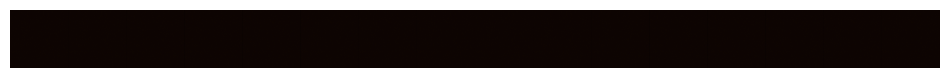

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([256, 8, 8])
torch.Size([16, 256, 8, 8])
torch.Size([128, 16, 16])
torch.Size([16, 128, 16, 16])
torch.Size([64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 128, 128])
torch.Size([16, 16, 128, 128])
torch.Size([8, 256, 256])
torch.Size([16, 8, 256, 256])
torch.Size([4, 512, 512])
torch.Size([16, 4, 512, 512])
torch.Size([2, 1024, 1024])
torch.Size([16, 2, 1024, 1024])
g shape torch.Size([16, 3, 1024, 1024])
torch.Size([16, 128, 512, 512])
torch.Size([16, 256, 256, 256])
torch.Size([16, 512, 128, 128])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 512, 8, 8])
torch.Size([16, 512, 4, 4])
torch.Size([16, 512])
torch.Size([16, 128, 512, 512])
torch.Size([16, 256, 256, 256])
torch.Size([16, 512, 128, 128])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 512, 8, 8])
torch.Size([16, 512, 4, 4])
torch.Si

2025-05-16 13:34:08,420 - INFO - cur_epoch:1,d_loss:1.8174937963485718


==========generator=============
torch.Size([256, 8, 8])
torch.Size([16, 256, 8, 8])
torch.Size([128, 16, 16])
torch.Size([16, 128, 16, 16])
torch.Size([64, 32, 32])
torch.Size([16, 64, 32, 32])
torch.Size([32, 64, 64])
torch.Size([16, 32, 64, 64])
torch.Size([16, 128, 128])
torch.Size([16, 16, 128, 128])
torch.Size([8, 256, 256])
torch.Size([16, 8, 256, 256])
torch.Size([4, 512, 512])
torch.Size([16, 4, 512, 512])
torch.Size([2, 1024, 1024])
torch.Size([16, 2, 1024, 1024])
torch.Size([16, 128, 512, 512])
torch.Size([16, 256, 256, 256])
torch.Size([16, 512, 128, 128])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 512, 8, 8])
torch.Size([16, 512, 4, 4])
torch.Size([16, 512])


In [ ]:
model=StyleGAN()
model.train(16)